In [136]:
import numpy as np
import numba
%matplotlib inline
import matplotlib.pyplot as plt

import scipy.signal as sg
from scipy.signal import stft

In [137]:
def morlet_wavelet(input_signal, dt=1, R=7, freq_interval=(), progress_signal = None, kill_switch = None):
    if kill_switch is None:
        kill_switch = [False]
    print('morlet_wavelet called')
    Ns = len(input_signal)
    if len(freq_interval) > 0:
        minf = max(freq_interval[0], R / (Ns * dt))  # avoid wavelets with COI longer than the signal
    else:
        minf = R / (Ns * dt)
    if len(freq_interval) > 1:
        maxf = min(freq_interval[1], .5 / dt)  # avoid wavelets above the Nyquist frequency
    else:
        maxf = .5 / dt
    if len(freq_interval) > 2:
            Nf = freq_interval[2]
    else:
        Nf = int(np.ceil(np.log(maxf / minf) / np.log(1 / R + 1)))  # make spacing aproximately equal to sigma f

    alfa = (maxf / minf) ** (1 / Nf) - 1  # According to the expression achived by fn = ((1+1/R)^n)*f0 where 1/R = alfa
    vf = ((1 + alfa) ** np.arange(0, Nf)) * minf
    print(Nf,Ns)
    result = np.zeros((Nf, Ns), dtype='complex')

    for k in range(Nf):
        if kill_switch[0]:
            break
        N = int(2 * R / vf[k] / dt)  # Compute size of the wavelet: 2 standard deviations
        wave = sg.morlet(N, w=R, s=1, complete=0) / N * np.pi * 2  # Normalize de amplitude returned by sg.morlet
        result[k, :] = sg.fftconvolve(input_signal, wave, mode='same')
        if progress_signal is not None:
            progress_signal.emit(int(100*k/Nf))

    mask = np.zeros(result.shape)

    Nlist = (.5 * R / vf / dt).astype('int')  # 3 sigma COI
    for k in range(len(Nlist)):
        mask[k, :Nlist[k]] = np.nan
        mask[k, -Nlist[k]:] = np.nan

    return (result, mask, vf, kill_switch)

In [202]:
def morlet_wavelet_fft(input_signal, dt=1, R=7, freq_interval=(), progress_signal = None, kill_switch = None):
    if kill_switch is None:
        kill_switch = [False]
    print('morlet_wavelet called')
    Ns = len(input_signal)
    if len(freq_interval) > 0:
        minf = max(freq_interval[0], R / (Ns * dt))  # avoid wavelets with COI longer than the signal
    else:
        minf = R / (Ns * dt)
    if len(freq_interval) > 1:
        maxf = min(freq_interval[1], .5 / dt)  # avoid wavelets above the Nyquist frequency
    else:
        maxf = .5 / dt
    if len(freq_interval) > 2:
            Nf = freq_interval[2]
    else:
        Nf = int(np.ceil(np.log(maxf / minf) / np.log(1 / R + 1)))  # make spacing aproximately equal to sigma f

    alfa = (maxf / minf) ** (1 / Nf) - 1  # According to the expression achived by fn = ((1+1/R)^n)*f0 where 1/R = alfa
    vf = ((1 + alfa) ** np.arange(0, Nf)) * minf
    print(Nf,Ns)
    result = np.zeros((Nf, Ns), dtype='complex')
    input_signalf = np.fft.fft(input_signal)
    
    for k in range(Nf):
        if kill_switch[0]:
            break
        N = int(2 * R / vf[k] / dt)  # Compute size of the wavelet: 2 standard deviations
        env = 2*np.exp(-(fs*np.arange(Ni)/Ni-vf[k])**2/(2*(vf[k]/R)**2))/np.pi
        result[k, :] = np.fft.ifft(input_signalf*env)
        if progress_signal is not None:
            progress_signal.emit(int(100*k/Nf))

    mask = np.zeros(result.shape)

    Nlist = (.5 * R / vf / dt).astype('int')  # 3 sigma COI
    for k in range(len(Nlist)):
        mask[k, :Nlist[k]] = np.nan
        mask[k, -Nlist[k]:] = np.nan

    return (result, mask, vf, kill_switch)

In [203]:
input_signal = test_signal
minf = 1
maxf = 125
fs = 250
Nf = int(np.ceil(np.log(maxf / minf) / np.log(1 / R + 1)))
alfa = (maxf / minf) ** (1 / Nf) - 1  # According to the expression achived by fn = ((1+1/R)^n)*f0 where 1/R = alfa
vf = ((1 + alfa) ** np.arange(0, Nf)) * minf
Ni = len(input_signal)
k = 69


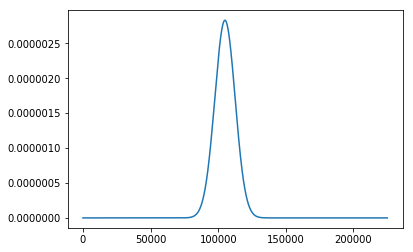

In [204]:
plt.plot(env)

In [205]:

test_signal = np.random.rand(15*60*250)

In [206]:
# %%timeit
test_wave = morlet_wavelet(test_signal,dt=1/250)

morlet_wavelet called
73 225000


/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The normal aspect was deprecated in version 1.2. Use auto instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


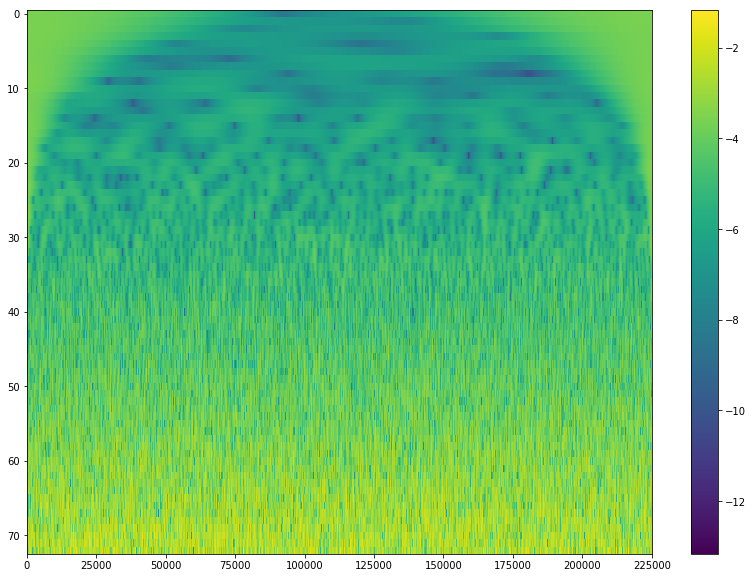

In [207]:
plt.figure(figsize=(14,10))
plt.imshow(np.log(np.abs(test_wave[0]))+.001, aspect='normal')
plt.colorbar()

In [208]:
# %%timeit
test_wave_fft = morlet_wavelet_fft(test_signal,dt=1/250)

morlet_wavelet called
73 225000


/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The normal aspect was deprecated in version 1.2. Use auto instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


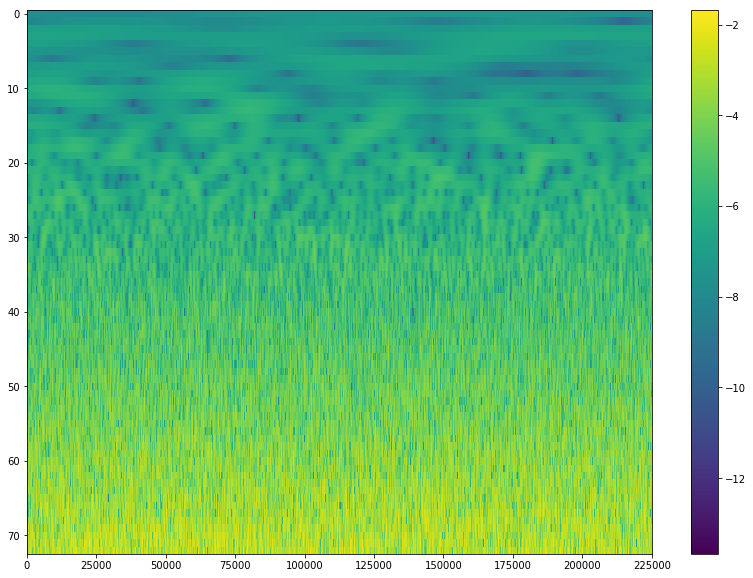

In [209]:
plt.figure(figsize=(14,10))
plt.imshow(np.log(np.abs(test_wave_fft[0]))+.001, aspect='normal')
plt.colorbar()

In [130]:
f = 20
R = 14
dt = 1/250
N = int(2 * R / f / dt)+1
wave = sg.morlet(N, w=R, s=1, complete=0) / N * np.pi * 2 
wavec = np.roll(wave,int(N/2)+1)

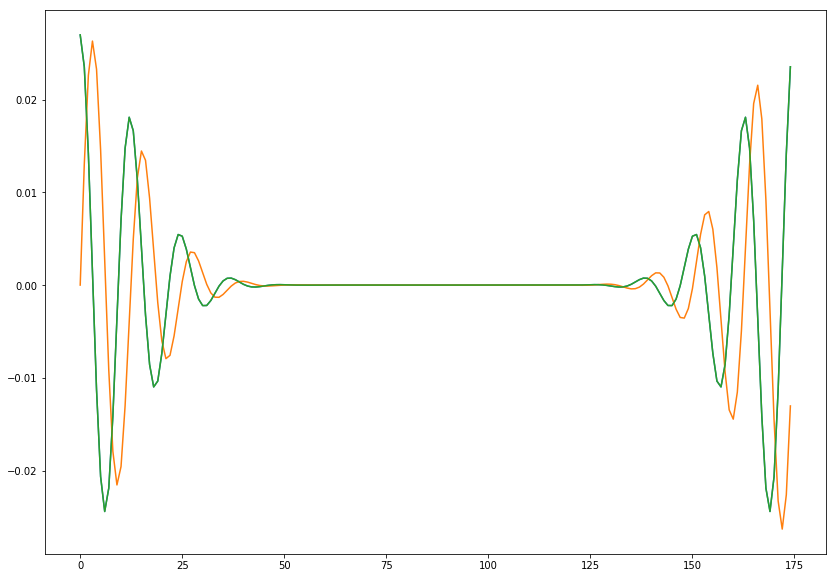

In [122]:
plt.figure(figsize=(14,10))
plt.plot(np.real(wavec))
plt.plot(np.imag(wavec))
plt.plot(np.real(np.fft.ifft(np.real(np.fft.fft(wavec)))))

In [129]:
14*250

3500

/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


10

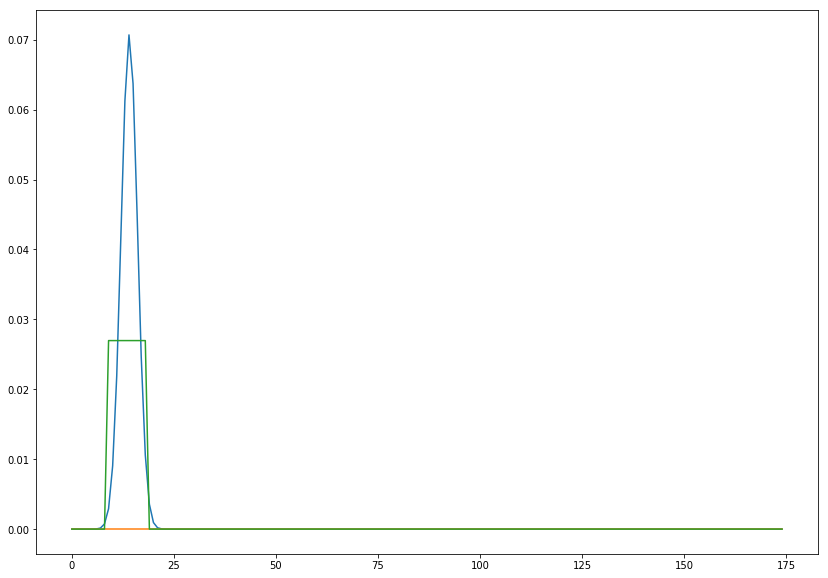

In [123]:
plt.figure(figsize=(14,10))
plt.plot(np.real(np.fft.fft(wavec))/np.sqrt(N))
plt.plot(np.imag(np.fft.fft(wavec))/np.sqrt(N))

fwave = np.real(np.fft.fft(wavec))/np.sqrt(N)
cumsumfwave = np.cumsum(fwave)
n = sum((cumsumfwave>.01*cumsumfwave[-1])*(cumsumfwave<.99*cumsumfwave[-1]))

plt.plot((cumsumfwave>.01*cumsumfwave[-1])*(cumsumfwave<.99*cumsumfwave[-1])*max(wavec))
n

In [128]:
2**14

16384

In [125]:
%%timeit
np.fft.fft(np.random.randn(2**10))

41.4 µs ± 16.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [126]:
%%timeit
np.fft.fft(np.random.randn(2**12))

159 µs ± 51.9 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [127]:
%%timeit
np.fft.fft(np.random.randn(2**14))

678 µs ± 7.89 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [158]:
nfft = 2**np.ceil(np.log2(R*250*1))
vf,t,z = stft(test_signal.T,fs = 250, nperseg=nfft,noverlap=nfft/2,window='rect') # avoid time edge values

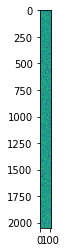

In [159]:
plt.imshow(np.log(abs(z)))

In [157]:
envlopes = np.zeros(nfft,len(vf))

(2049, 111)

In [214]:
a = float('inf')

In [215]:
a

inf